# PotentioDynamic Scattering Microscopy (PDSM)

## Contrast oscillation analysis
 
Author: ``Sanli Faez (s.faez@uu.nl)``

version: 12/09/2018 [adapted to measurements done in Oxford] 

The main use of this notebook is to analyze the scattering contrast oscillations at the surface of a transparent slab while an alternating potential is applied.

* Part 1) preprocessing and previewing data
* Part 2) constucting the contrast oscillation map
* Part 3) summarizing the results


### Preparation: Import necessary modules

In [15]:
%pylab inline

import sys
sys.path.append('/Users/sanli/Repositories/PDSM') #uncomment including extra files are needed

import nptdms  #needed for image-series that are recorded with Labview
import matplotlib.pyplot as plt
import numpy as np
# from PDSM_func import tdms


Populating the interactive namespace from numpy and matplotlib


## 1) Read data and preprocess
### 1.1) Choose data file and fill in measurement attributes

In [27]:
filedir = r'/Users/sanli/Repositories/Data/PDSM_UnderInvestigation/Shawn/ITO_17mW_1ms_2mM_NaCl/'
mfile = 'event3.tdms'
filename = filedir + mfile
print(filename)
outputdir = filedir

attributes=nptdms.TdmsFile(filename).object("img","cam2").properties
print(attributes)
efr = attributes['Frame Rate']
# put the correct recording details for each file below, is needed for processing
#nf = 2000  #length of the recorded sequence
period = 2 #period of the applied (sine) potential in seconds

/Users/sanli/Repositories/Data/PDSM_UnderInvestigation/Shawn/ITO_17mW_1ms_2mM_NaCl/event3.tdms
OrderedDict([('Frame Rate', 297.0), ('Exposure Time', 0.0), ('Bin Frame Size', 1.0), ('Pixel Size', 512.0), ('Lost frames during acq', 0.0)])


### 1.2) Put all data from a sequence into an image-cube without any processing

In [28]:
f = nptdms.TdmsFile(filename)
data_raw = f.channel_data('img', 'cam2')
attributes = f.object("img" , 'cam2').properties
Ly = int(attributes['Pixel Size'])
Lx = Ly
N = data_raw.size//(Ly*Lx)
frames = data_raw[:N*Lx*Ly].reshape(N, Ly, Lx)
# frames = tdms.read_tdms(filename, do_remove_empty_frames=False, do_check_no_duplicates=False)
nf = frames.shape[0]
print(nf, "frames in the sequence")

3800 frames in the sequence


### 1.3) Check some frames to see the drift between first and last frame

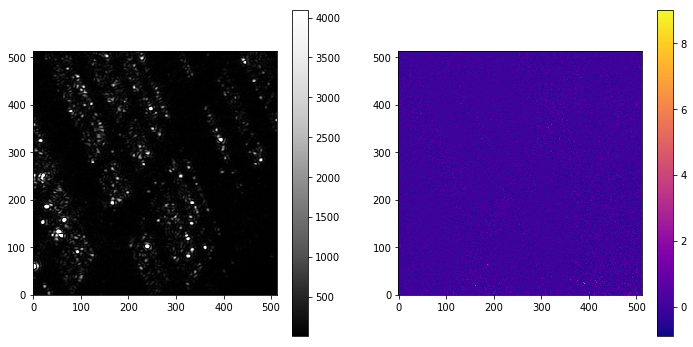

In [29]:
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
im = ax1.imshow(frames[0], cmap='Greys_r', origin ='lower')
plt.colorbar(im, ax = ax1)

ax2 = plt.subplot(122)
drift = (frames[nf-1]-frames[0])/frames[0]
im = ax2.imshow(drift, cmap='plasma', origin ='lower')
plt.colorbar(im, ax = ax2)

plt.show()

### 1.4) Save a couple of images for further reference

In [85]:
previewfile = outputdir + mfile.strip('.tdms')+'_rawImage.npy'
np.save(previewfile, frames[0])
meandrift = np.std(drift)
print(meandrift)

0.00517512251087


### 1.6) Subtract the average and look for oscilating spots


average counts: 132.238706169


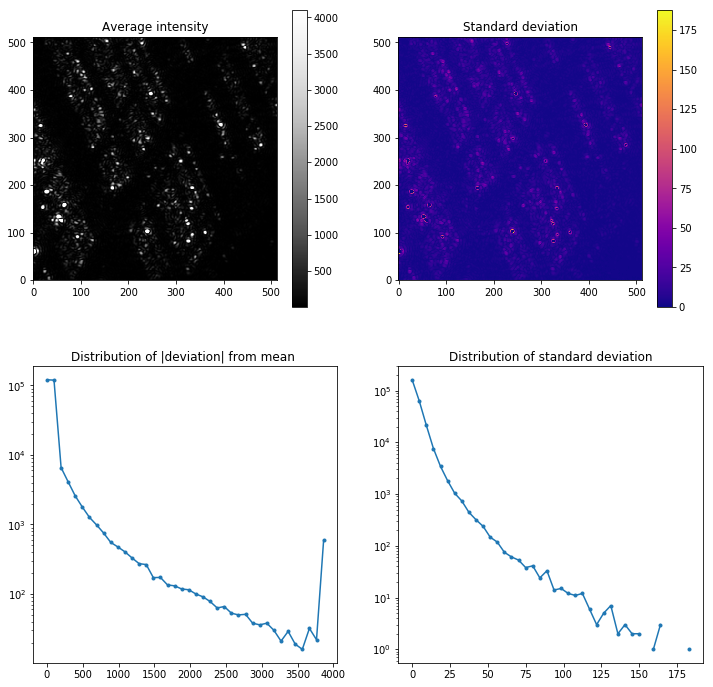

In [30]:
mean_img = np.mean(frames, axis=0)
dframes = np.copy(frames)
for i in range(nf):
    dframes[i] = frames[i] - mean_img
    
print("average counts:", np.mean(mean_img))

var_img = np.std(dframes, axis=0) #/ mean_img
contrast_img = np.abs(mean_img - np.mean(mean_img))

nbins = 40
hist_img, bin_edges_img = np.histogram(contrast_img, bins = nbins)
hist_var, bin_edges_var = np.histogram(var_img, bins = nbins)


fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(221)
im1 = ax1.imshow(mean_img, cmap='Greys_r', origin ='lower')
plt.colorbar(im1, ax = ax1)
plt.title("Average intensity")

ax2 = plt.subplot(222)
im2 = ax2.imshow(var_img, cmap='plasma', origin ='lower')
plt.colorbar(im2, ax = ax2)
plt.title("Standard deviation")

ax3 = plt.subplot(223)
im3 = ax3.semilogy(bin_edges_img[:nbins], hist_img, '.-')
plt.title("Distribution of |deviation| from mean ")

ax4 = plt.subplot(224)
im4 = ax4.semilogy(bin_edges_var[:nbins], hist_var, '.-')
plt.title("Distribution of standard deviation")

previewfile = outputdir + mfile.strip('.tdms')+'_std.png'
plt.savefig(previewfile)
plt.show()



### 1.7) Use one spot to optimized the time fourier filtering

max variations at  [55, 2]
least variations at  (56, 0)


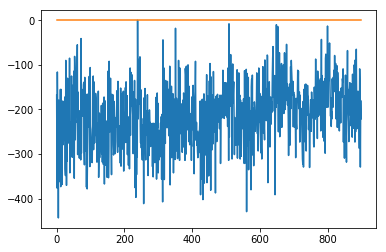

In [37]:
spotmax = np.unravel_index(np.argmax(var_img[:100,:100], axis=None), var_img[:100,:100].shape)
spotmin = np.unravel_index(np.argmin(var_img, axis=None), var_img.shape)

spotmax = [spotmax[0], spotmax[1]]
print("max variations at ", spotmax)
print("least variations at ", spotmin)
#spotmax = (36, 77)

response = dframes[:900,spotmax[0],spotmax[1]]
responsemin = dframes[:900,spotmin[0],spotmin[1]]
plt.plot(response)
plt.plot(responsemin)
plt.show()

### 1.8) Find the Fourier components corresponding to the oscillating potential

Fourier components: 27


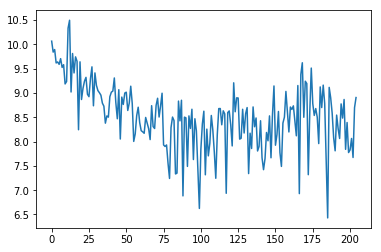

1901


In [35]:
fspec = np.fft.rfft(response)
dcbase = 15   #fourier index below which counts as drift
plt.plot(np.log(abs(fspec[dcbase:220])))
# plt.plot(np.angle(fspec[dcbase:220]))

mfreq = dcbase + np.argmax(abs(fspec[dcbase:520]))
#shfreq = mfreq + dcbase + np.argmax(abs(fspec[mfreq + dcbase:]))
#thirdfreq = shfreq + dcbase + np.argmax(abs(fspec[shfreq + dcbase:]))

print("Fourier components:", mfreq)
#plt.plot(np.arange(mfreq-1,mfreq+2), abs(fspec[mfreq-1:mfreq+2]), '.')
plt.show()
print(fspec.size)

### 1.9) Calculate auto-correlation of the signal to look at the waveform

ValueError: x and y must have same first dimension, but have shapes (7604,) and (1900,)

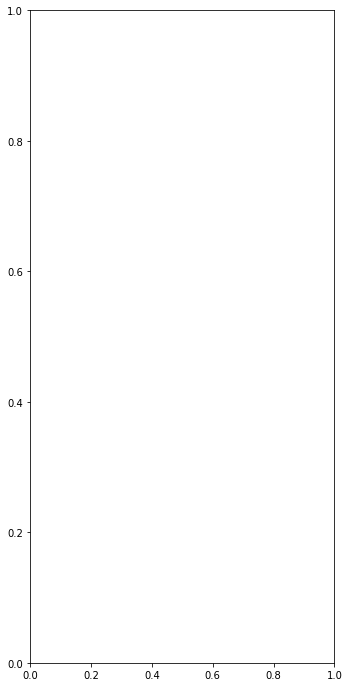

In [33]:
fspec[:dcbase] = 0
#nf = 2*(fspec.size-1)
maxfreq = 300
fspec[maxfreq:] = 0
filtered = np.fft.irfft(fspec)
corr_response = np.correlate(filtered, filtered, mode="same")
dis_period = 4*int(fspec.size/mfreq)

fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(121)
taxis = np.arange(dis_period)/efr
waveform = corr_response[int(nf/2):int(nf/2)+(dis_period)]/corr_response[int(nf/2)]
ax1.plot(taxis, waveform)
plt.title("Normalized autocorrelation")
plt.xlabel("Shift (seconds)")
#ax1.plot(corr_response)

aaxis = np.cos(np.arange(dis_period)/dis_period*2*np.pi)
ax2 = plt.subplot(122)
#ax2.plot(aaxis, waveform)
ax2.semilogy(abs(fspec[:maxfreq]/np.max(abs(fspec)))**2)
corr_fft = np.abs(np.fft.rfft(corr_response))

ax2.semilogy(corr_fft[:maxfreq]/np.max(corr_fft))
plt.title("Power spectrum")

previewfile = outputdir + mfile.strip('.tdms')+'_PowerSpectrum.png'
fig.savefig(previewfile)

### 1.10) Extensive averaging procedure for obtaining the most likely wavform 
to be further explored

### 2) Summarize seqeunce based on mapping the fourier components

In [ ]:
## Just checking background noise, comment following lines when analyzing oscillating contrasts
mfreq = 27
# shfreq = 63

ffpwidth = 3 #estimated half width of the Fourier peak in the power spectrum
frames_fft = np.fft.rfft(dframes, axis=0)
first_harmonic = np.sum(np.abs(frames_fft[mfreq-ffpwidth:mfreq+ffpwidth+1]), axis=0)

phase = np.angle(frames_fft[mfreq])

fig = plt.figure(figsize=(12,12))
ax1 = plt.subplot(221)
im = ax1.imshow(first_harmonic/nf, cmap='Greys_r', origin ='lower')
plt.colorbar(im, ax = ax1)
plt.title("First harmonic")

index = 42 #index of line for sample values
first_harmonic_line = first_harmonic[:,index]/nf
mean_line = mean_img[:,index] * np.mean(first_harmonic_line) / np.mean(mean_img[:,index])

ax2 = plt.subplot(222)
ax2.plot(first_harmonic_line)
ax2.plot(mean_line)
plt.title("First harmonic vs intensity on column "+str(index))

ax3 = plt.subplot(223)
im = ax3.imshow(mean_img, cmap='Greys_r', origin ='lower')
plt.colorbar(im, ax = ax3)
plt.title("Average intensity")

nbins = 40
hist_harmonic, bin_edges_harmonic = np.histogram(first_harmonic/nf, bins = nbins)

ax4 = plt.subplot(224)
ax4.semilogy(bin_edges_harmonic[:nbins], hist_harmonic, '*-')
ax4.semilogy(bin_edges_var[:nbins], hist_var, '.-')
plt.title("Distribution of harmonic amplitudes and STD")

plt.show()

#saving some of the data
previewfile = outputdir + mfile.strip('.tdms')+'_Summary.png'
fig.savefig(previewfile)

output = outputdir + mfile.strip('.tdms')+'_firstharmonic.npy'
np.save(output, first_harmonic/nf)

In [96]:
print("Average intensity:", np.mean(mean_img), np.std(mean_img))
print("Average harmonic signal:", np.mean(first_harmonic)/nf, np.std(first_harmonic)/nf)

Average intensity: 2801.93423174 267.924622802
Average harmonic signal: 10.3201723694 3.41590775892


### optional: Set parameters for creating a video

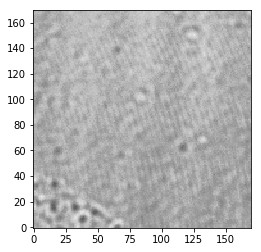

290


In [95]:
vmin = -50
vmax = 50
ticks = [vmax,vmin]
tick_labels = ['%.3f' %vmax, '%.3f' %vmin]

start_frame = 1700
N_frames = np.int(4 * period * efr)
data = dframes[start_frame : start_frame + N_frames]
    
nf, sy, sx = data.shape
nm_px = 21 * 3

fig = plt.figure()
ax = plt.subplot(111)
im = ax.imshow(data[0], cmap='Greys_r', vmin=vmin, vmax=vmax, origin ='lower')
plt.show()
print(N_frames)

### optional (cont.) Save video

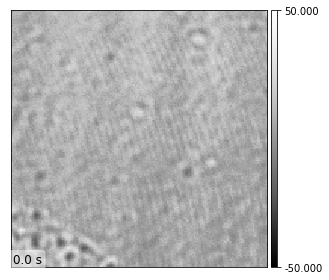

In [96]:
#matplotlib.rcParams['mathtext.fontset'] = 'stixsans'
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation


fig = plt.figure()
ax = plt.subplot(111)

def microns(x, pos):
    return '%.2f' % (x*nm_px/1000)

#formatter = FuncFormatter(microns)
#ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_locator(FixedLocator([0, sx/4, sx/2, 3*sx/4, sx-.5]))
#ax.yaxis.set_major_locator(FixedLocator([0, sy/4, sy/2, 3*sy/4, sy-.5]))
plt.xticks([])
plt.yticks([])
im = ax.imshow(np.zeros_like(data[0]), cmap='Greys_r', vmin=vmin, vmax=vmax, origin ='lower')
time_text = ax.text(1, 1.75, '0', fontsize = 12, bbox=dict(boxstyle='round', fc='w', alpha=0.5, ec='none'))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.05)
cbar = fig.colorbar(im, cax=cax, ticks=ticks)
#cbar.ax.invert_yaxis()
cbar.ax.set_yticklabels(tick_labels)
plt.tight_layout()

def update_img(i):
    im.set_data(data[i])
    time_text.set_text('%.1f s' % (i/efr))
    return im

ani = animation.FuncAnimation(fig, update_img, frames = N_frames)
def ani_save(vformat, fps):
    if vformat == 'mp4':
        ani.save(filename.strip('.tdms')+'.mp4', writer = 'ffmpeg', fps=fps, dpi = 200, bitrate=1215)
    elif vformat == 'ogv':
        ani.save(filename.strip('.tdms')+'.ogv', writer = 'ffmpeg', codec='libtheora', fps=fps, dpi = 200, bitrate=1215)
    elif vformat == 'webm':
        ani.save(filename.strip('.tdms')+'.webm', writer = 'ffmpeg', codec='libvpx-vp9', fps=fps, dpi = 200, bitrate=1215)
    elif vformat == 'avi':
        ani.save(filename.strip('.tdms')+'.avi', writer = 'ffmpeg', codec='ffv1', fps=fps, dpi = 200, bitrate=1215)

ani_save('avi', 32)